# Visualizing STSS Oracle Results on Real Data

This notebook demonstrates the **STSS Offline Oracle** using real trajectory data from `data/raw/subset_50`.

In [76]:
import sys
from pathlib import Path

project_root = Path("../").resolve()
if str(project_root / "src") not in sys.path:
    sys.path.append(str(project_root / "src"))
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import geopandas as gpd
from shapely.geometry import Point as ShapelyPoint, LineString
import matplotlib.pyplot as plt
import contextily as cx
import pandas as pd

from hysoc.core.point import Point
from hysoc.core.segment import Segment, Stop, Move
from hysoc.core.stream import TrajectoryStream
from benchmarks.oracles.stss_sklearn import STSSOracleSklearn
from benchmarks.oracles.stss_manual import STSSOracleManual

In [77]:
# Loading Real Data
data_dir = project_root / "data" / "raw" / "subset_50"

# Manually set filename here
FILENAME = "4494499.csv"  # <--- Change this ID to visualize different files

trajectory_file = data_dir / FILENAME

if trajectory_file.exists():
    print(f"Loading: {trajectory_file.name}")
    df = pd.read_csv(trajectory_file)
    print(df.head())
    
    traj = []
    for _, row in df.iterrows():
        # Adjust column names if needed
        lat = row.get('lat') or row.get('latitude') or row.get('LAT')
        lon = row.get('lon') or row.get('longitude') or row.get('LON')
        ts = row.get('timestamp') or row.get('time') or row.get('date_time')
        oid = row.get('obj_id') or row.get('id') or "unknown"
        
        traj.append(Point(
            lat=float(lat),
            lon=float(lon),
            timestamp=pd.to_datetime(ts),
            obj_id=str(oid)
        ))
    print(f"Loaded {len(traj)} points.")
else:
    print(f"File not found: {trajectory_file}")
    traj = []

Loading: 4494499.csv
                  time   latitude  longitude  altitude  osm_way_id  \
0  2022-06-23 16:25:08  40.609330 -73.969993   -31.567   297831432   
1  2022-06-23 16:25:09  40.609330 -73.969992   -31.762   297831432   
2  2022-06-23 16:25:10  40.609329 -73.969991   -32.284   297831432   
3  2022-06-23 16:25:11  40.609329 -73.969990   -32.395   297831432   
4  2022-06-23 16:25:12  40.609328 -73.969989   -32.529   297831432   

   matched_latitude  matched_longitude  matched_distance  matched_type  
0         40.609328         -73.970003          0.954074          True  
1         40.609328         -73.970003          0.989352         False  
2         40.609327         -73.970003          1.072918         False  
3         40.609327         -73.970003          1.163226         False  
4         40.609326         -73.970003          1.228607         False  
Loaded 616 points.


In [78]:
# --- PARAMETERS ---
# Tweak these to change sensitivity of stop detection

# minimum number of points to form a cluster
MIN_SAMPLES = 5

# maximum distance (meters) between points to be considered neighbors
# INCREASE this if stops are not detected (e.g. 50.0 -> 100.0 or 200.0)
MAX_EPS = 10

# minimum duration (seconds) to be considered a stop
# DECREASE this if short stops are being filtered out (e.g. 120.0 -> 60.0)
MIN_DURATION = 10

# Run Oracle
if traj:
    print(f"Running Oracle with: min_samples={MIN_SAMPLES}, max_eps={MAX_EPS}m, min_dur={MIN_DURATION}s")
    
    oracle = STSSOracleSklearn(min_samples=MIN_SAMPLES, max_eps=MAX_EPS, min_duration_seconds=MIN_DURATION)
    segments = oracle.process(traj)
    print(f"Detected {len(segments)} segments.")
    
    # Quick stats
    n_stops = sum(1 for s in segments if isinstance(s, Stop))
    n_moves = sum(1 for s in segments if isinstance(s, Move))
    print(f" - Stops: {n_stops}")
    print(f" - Moves: {n_moves}")
    
    if n_stops == 0:
        print("\nWARNING: No stops detected! Try increasing MAX_EPS or decreasing MIN_DURATION.")

Running Oracle with: min_samples=5, max_eps=10m, min_dur=10s
Detected 27 segments.
 - Stops: 13
 - Moves: 14


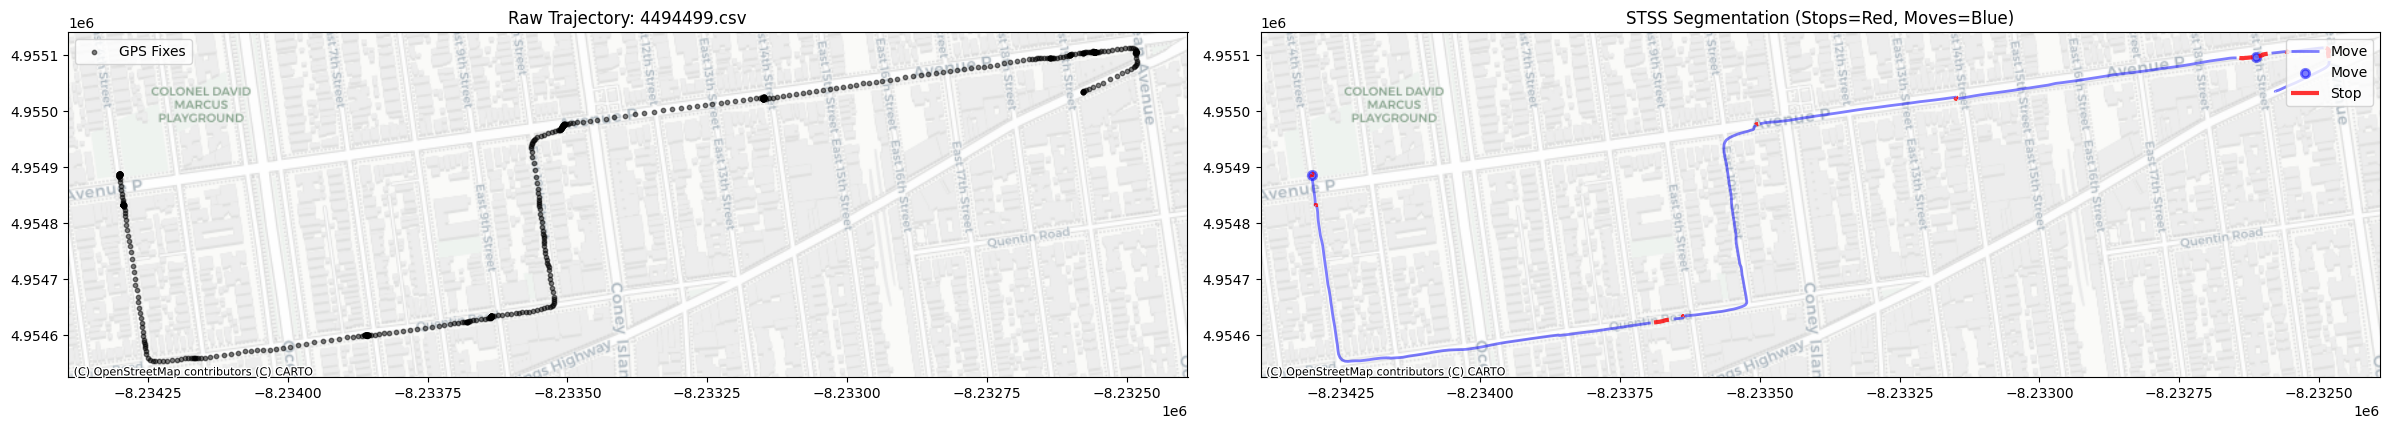

In [79]:
def segments_to_gdf(segments):
    data = []
    for i, seg in enumerate(segments):
        seg_type = type(seg).__name__
        if not seg.points:
            continue
            
        if len(seg.points) < 2:
            geom = ShapelyPoint(seg.points[0].lon, seg.points[0].lat)
        else:
            coords = [(p.lon, p.lat) for p in seg.points]
            geom = LineString(coords)
            
        data.append({
            "segment_id": i,
            "type": seg_type,
            "start_time": seg.start_time,
            "end_time": seg.end_time,
            "geometry": geom
        })
    return gpd.GeoDataFrame(data, crs="EPSG:4326")

if traj and segments:
    # 1. Prepare Segments GDF
    gdf_segs = segments_to_gdf(segments)
    gdf_segs_web = gdf_segs.to_crs(epsg=3857)
    
    # 2. Prepare Raw Points GDF
    raw_points = [{'geometry': ShapelyPoint(p.lon, p.lat)} for p in traj]
    gdf_raw = gpd.GeoDataFrame(raw_points, crs="EPSG:4326")
    gdf_raw_web = gdf_raw.to_crs(epsg=3857)
    
    # 3. Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))
    
    # --- Left Plot: Raw Points ---
    ax0 = axes[0]
    gdf_raw_web.plot(ax=ax0, color='black', markersize=10, alpha=0.5, label='GPS Fixes')
    try:
        cx.add_basemap(ax0, source=cx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Basemap error: {e}")
    ax0.set_title(f"Raw Trajectory: {FILENAME}")
    ax0.legend()
    
    # --- Right Plot: Segmentation ---
    ax1 = axes[1]
    
    moves = gdf_segs_web[gdf_segs_web['type'] == 'Move']
    if not moves.empty:
        moves.plot(ax=ax1, color='blue', linewidth=2, alpha=0.5, label='Move')
        
    stops = gdf_segs_web[gdf_segs_web['type'] == 'Stop']
    if not stops.empty:
        stops.plot(ax=ax1, color='red', linewidth=3, alpha=0.8, label='Stop')
        
    try:
        cx.add_basemap(ax1, source=cx.providers.CartoDB.Positron)
    except Exception as e:
        pass
        
    ax1.set_title(f"STSS Segmentation (Stops=Red, Moves=Blue)")
    ax1.legend()

    plt.tight_layout()
    plt.show()